In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def determine_site_dist(map, depth, freq, info, depth_thres = 1):
    """For all sites, determine if they are fixed or polymorphic"""

    Dist = []
    for i in range(info.shape[0]):
        # Add samples IDs as map header and match samples
        # in map with samples in depth

        # Create site data frame
        site = map.copy()
        site['depth'] = depth.loc[ depth.index[i], map.index ]
        site['freq'] = freq.loc[ freq.index[i], map.index ]

        # Remove samples without information for site
        site = site[site.depth >= depth_thres]

        # Determine if it is polymorphic or fixed
        site_crosstab = pd.crosstab(site.freq >= 0.5, site.Group)
        if site_crosstab.shape == (2,2):
            if (np.matrix(site_crosstab).diagonal() == [0,0]).all() or (np.fliplr(np.matrix(site_crosstab)).diagonal() == [0, 0]).all():
                mutation_type = 'fixed'
            else:
                mutation_type = 'polymorphic'
        else:
            mutation_type = np.nan

        Dist.append(mutation_type)
    
    return(Dist)

In [3]:
def determine_mutation_effect(r):
    """Mini function for apply, takes a series and checks if the mutation
    is synonymous (s) or non-synonymopus (n)"""
    
    ii = r.loc[['count_a', 'count_c', 'count_g', 'count_t']] > 0
    aa = np.array(r.amino_acids.split(sep=','))

    if all(aa[ii][0] == aa[ii]):
        effect = 's'
    else:
        effect = 'n'

    return effect

In [4]:
def mktest_fisher_exact(g):
    """Per perform the fisher's exact test on a gene MK 
    contingency table."""
    
    tab = np.array([[g.Dn,g.Pn],[g.Ds,g.Ps]])
    oddsratio, pval = stats.fisher_exact(tab, alternative='two-sided')
    # oddsratio, pval = stats.fisher_exact(tab, alternative='greater')
    
    return pval

In [5]:
def read_and_process_data(map_file, info_file, depth_file, freqs_file,
                         groups, cov_thres=1):
    """Reads MIDAS output files, selects gene sites and samples above threshold,
    determines mutation effect (s or n) and makes sure files are consistent
    with each other"""
    
    # Read data
    info = pd.read_csv(info_file, sep="\t")
    depth = pd.read_csv(depth_file, sep="\t")
    freq = pd.read_csv(freqs_file, sep="\t")

    # Remove non gene sites
    ii = ~info.gene_id.isnull()
    info = info.loc[ii, :]
    depth = depth.loc[ii, :]
    freq = freq.loc[ii, :]

    # Remove site_id columns
    depth = depth.drop(axis=1, labels='site_id')
    freq = freq.drop(axis=1, labels='site_id')

    # subset for tests
    # info = info.head(1000)
    # depth = depth.head(1000)
    # freq = freq.head(1000)

    # Determine effect of sites (this is constant and indepentent of samples)
    info['Effect'] = info.apply(determine_mutation_effect, axis=1)
    
    # Check that sample names match between freq and depth
    if not all(freq.columns == depth.columns):
        raise ValueError("Columns don't match between freq and depth files")

        
    # Read map file and select groups
    map = pd.read_csv(map_file, sep="\t")
    map.index = map.ID
    map = map.loc[map.Group.isin(groups),:].copy()
    
    # Remove samples from other groups
    ci = depth.columns.isin(map.ID)
    depth = depth.loc[:, ci]
    freq = freq.loc[:, ci]

    # Reorder map
    map = map.loc[depth.columns,:]

    # Calculate coverage in sites
    map['coverage'] = depth.mean(axis=0)

    # Remove samples below coverage
    ci = map.coverage >= cov_thres
    map = map.loc[ci, :]
    depth = depth.loc[:, map.index]
    freq = freq.loc[:, map.index]
    
    return map, freq, info, depth

In [6]:
def calculate_mk_oddsratio(map, info, depth, freq, depth_thres=1):
    """Determine if sites are fixed of polymorphic, calculate MK
    contingency table per gene, and calculate odds ratio"""
    
    if not all(map.index == depth.columns):
        raise ValueError("Samples in map and depth don't match")
    if not all(map.index == freq.columns):
        raise ValueError("Samples in map and freq don't match")
    if not all(freq.columns == depth.columns):
        raise ValueError("Samples in freq and depth don't match")

    # Determine type of mutation
    info['Type'] = determine_site_dist(map=map, depth=depth, freq=freq, info=info, depth_thres=depth_thres)
    
    # Calculate MK contingency table per gene
    Genes = pd.DataFrame(columns=['Gene', 'Dn', 'Ds', 'Pn', 'Ps'])
    for g in info.gene_id.unique():
        dat = info.loc[info.gene_id == g,:].copy()
        tab = pd.crosstab(dat.Effect, dat.Type, rownames=['Effect'], colnames=['Type'])
        tab = tab.reindex(index=pd.Index(['n','s']), columns=pd.Index(['fixed', 'polymorphic']), fill_value=0)
        s = pd.Series(g, index=['Gene']).append(tab.fixed).append(tab.polymorphic)
        Genes = Genes.append(pd.DataFrame([list(s)], columns=Genes.columns), ignore_index=True)
        
    # Calculate ratio
    np.seterr(divide='ignore', invalid='ignore')
    Genes['ratio'] = pd.to_numeric(Genes.Dn * Genes.Ps) / pd.to_numeric(Genes.Ds * Genes.Pn)
    np.seterr(divide='raise', invalid='raise')
    Genes.replace(np.inf, np.nan, inplace=True)
    # Genes['hg.pval'] = Genes.apply(mktest_fisher_exact, axis=1)
    # Genes.head()
    
    return Genes, info

In [7]:
map_file = "/home/sur/micropopgen/data/test_data/midas/map.txt"
depth_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_depth.txt"
info_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_info.txt"
freqs_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_freq.txt"
groups = ['Buccal mucosa', 'Tongue dorsum']
depth_thres = 1
cov_thres = 3
nperm = 9

In [8]:
map, freq, info, depth = read_and_process_data(map_file=map_file, info_file=info_file,
                                               depth_file=depth_file, freqs_file=freqs_file,
                                               groups=groups, cov_thres=cov_thres)
Genes, info = calculate_mk_oddsratio(map=map, info=info, depth=depth, freq=freq, depth_thres=depth_thres)

In [11]:
if nperm > 0:
    Perms = np.empty((Genes.shape[0], nperm + 1))
    Perms[:] = np.nan
    Perms[:, 0] = Genes.ratio
    np.random.seed(5)
    for i in range(1,nperm + 1):
        # print(i)
        map_i = map.copy()
        map_i['Group'] = np.random.permutation(map_i.Group)
        Genes_i, info_i = calculate_mk_oddsratio(map=map_i, info=info, depth=depth,
                                                 freq=freq, depth_thres=depth_thres)
        Perms[:, i] = Genes_i.ratio
    # Perms

    # Calculate permutation p-values
    Genes['nperm'] = nperm + 1 - pd.isnull(Perms).sum(axis=1)
    np.seterr(invalid='ignore', divide='ignore')
    Genes['P'] = np.greater_equal(Perms[: ,np.repeat(0 ,nperm + 1)],Perms).sum(axis=1) / Genes['nperm']
    np.seterr(invalid='raise', divide='raise')

# Genes.head()

,Gene,Dn,Ds,Pn,Ps,ratio,nperm,P
0,1316408.3.peg.1,0.0,7.0,1.0,20.0,0.000000,6,1.000000
1,1316408.3.peg.2,4.0,11.0,6.0,12.0,0.727273,6,0.666667
2,1316408.3.peg.3,2.0,15.0,7.0,56.0,1.066667,6,0.333333
3,1316408.3.peg.4,3.0,4.0,3.0,10.0,2.500000,7,1.000000
4,1316408.3.peg.5,0.0,0.0,2.0,10.0,NaN,4,0.000000


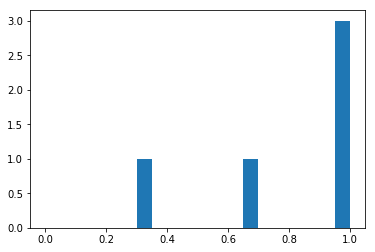

In [13]:
# Plot historgram of permutation p-values
plt.hist(Genes['P'][~pd.isnull(Genes.ratio)], bins=20, range=(0,1));

In [15]:
# Calculate hg #p-value for analysis
Genes['fisher_pval'] = Genes.apply(mktest_fisher_exact, axis=1)

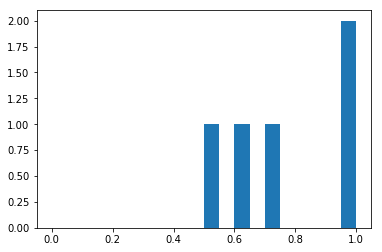

In [16]:
# Plot historgram of permutation p-values
plt.hist(Genes['fisher_pval'][~pd.isnull(Genes.ratio)], bins=20, range=(0, 1));

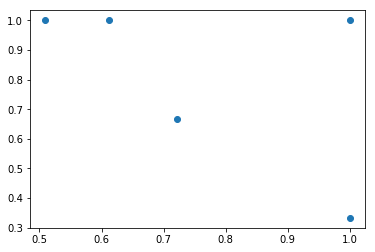

In [17]:
# Compare p-values from perm and fisher exact
plt.plot(Genes['fisher_pval'][~pd.isnull(Genes.ratio)], Genes['P'][~pd.isnull(Genes.ratio)],"o");

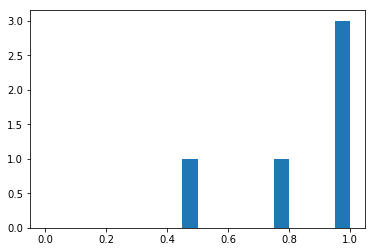

In [96]:
def overall_pval(s, dist):
    # c = (s >= dist).sum()
    c = np.logical_or(s >= dist, np.divide(1,s) <= dist).sum()
    p = c / len(dist)
    
    return p

dist = Perms.flatten()
dist = dist[~pd.isnull(dist)]

np.seterr(divide='ignore', invalid='ignore')
Genes['overall_P'] = Genes.ratio.apply(overall_pval, args=(dist,))
np.seterr(divide='raise', invalid='raise')
# Genes
# Plot historgram of overall permutation p-values
plt.hist(Genes['overall_P'][~pd.isnull(Genes.ratio)], bins=20, range=(0, 1));

In [98]:
Genes.head(20)


,Gene,Dn,Ds,Pn,Ps,ratio,nperm,P,fisher_pval,overall_P
0,1316408.3.peg.1,0.0,7.0,1.0,20.0,0.000000,6,1.000000,1.000000,0.456140
1,1316408.3.peg.2,4.0,11.0,6.0,12.0,0.727273,6,0.666667,0.722024,0.789474
2,1316408.3.peg.3,2.0,15.0,7.0,56.0,1.066667,6,0.333333,1.000000,1.000000
3,1316408.3.peg.4,3.0,4.0,3.0,10.0,2.500000,7,1.000000,0.612616,1.000000
4,1316408.3.peg.5,0.0,0.0,2.0,10.0,NaN,4,0.000000,1.000000,0.000000
5,1316408.3.peg.6,5.0,10.0,14.0,46.0,1.642857,6,1.000000,0.509556,1.000000
6,1316408.3.peg.7,0.0,0.0,3.0,11.0,NaN,2,0.000000,1.000000,0.000000
7,1316408.3.peg.8,0.0,0.0,1.0,7.0,NaN,2,0.000000,1.000000,0.000000
8,1316408.3.peg.9,0.0,0.0,4.0,8.0,NaN,4,0.000000,1.000000,0.000000
9,1316408.3.peg.10,0.0,0.0,1.0,5.0,NaN,4,0.000000,1.000000,0.000000


In [ ]:
# Compare p-values from overperm and fisher exact
plt.plot(Genes['fisher_pval'][~pd.isnull(Genes.ratio)], Genes['P'][~pd.isnull(Genes.ratio)],"o");

In [18]:
# Profiling estimation
%load_ext line_profiler

In [19]:
%prun calculate_mk_oddsratio(map=map, info=info, depth=depth, freq=freq, depth_thres=depth_thres)

In [25]:
%lprun -u 1e-3 -f calculate_mk_oddsratio calculate_mk_oddsratio(map=map, info=info, depth=depth, freq=freq, depth_thres=depth_thres)

In [26]:
%lprun -u 1e-3 -f determine_site_dist determine_site_dist(map=map, depth=depth, freq=freq, info=info, depth_thres=depth_thres)